<h4> Caso de estudio usando redes neuronales: alometría de la proporción cabeza/ojo en una especie de pez óseo </h4>
<h4> (Neural network study case: alometry of head/eye ratio in a species of fish) </h4>
<h5> Este script contiene: 
<ul>
	<li>El uso de una red neuronal artificial (ANN) para modelar la relación entre la proporción altura de cabeza/diámetro de ojo y la longitud total en una especie de pez óseo (Sebastes oculatus)</li>
    <li>Gráficos del modelo final y del resultado del proceso de entrenamiento de la ANN</li>
	<li>Cálculo de R2 (coeficiente de determinación) y error relativo</li>
    <li>Comparación del modelo de red neuronal con una regresión lineal clásica</li>
</ul>
</h5>

<h5><b>Configuración básica</b></h5>
<h6>Importamos librerías, configuramos los gráficos </h6>

In [52]:
import numpy as np                          ## Computación científica (vectores, matrices, etc.)
import torch                                ## Framework de redes neturonales
from torch import nn 
from torch.utils.data import Dataset,DataLoader
## Librerías de visualización
import matplotlib.pyplot as plt             ## Gráficos varios
import pandas as pd
import dill
import json
import datetime
import os
try:
  import google.colab
  from google.colab import files  
  COLAB = True
except:
  COLAB = False

## Configuración general
import seaborn as sns 
sns.set()                                   
sns.set_context('talk')
%matplotlib inline

In [53]:
#Working directory:
#cwd = os.getcwd()
#cwd

En el siguiente bloque vemos si la GPU está disponible. Si lo está, la utilizaremos, y si no, usaremos una CPU.

In [54]:
## Elegimos si usar CPU o GPU para los cálculos
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


<h5><b>Cargamos el dataset</b></h5>

In [55]:
##leo csv y convierto datos a tensores de torch

#str = unicode(str, errors='replace')

#REPLACE FOR YOUR PC ROUTE:
df=pd.read_csv('C:\\Users\\merlo\\Documents\\Doctorado\\CapituloI_LengthEstimations\\fitmodel_df.csv',encoding='unicode_escape')

# "Escrófalo" es el nombre común en español de la especie de interés (Escrófalo is the spanish common name of the target species) 
tab_escrofalo = df[(df['Especie']=='Escrofalo')][['Radio_AC_AO','Total_length']].reset_index(drop=True)
np_escrofalo=tab_escrofalo.to_numpy(copy=True)
n_muestras = len(np_escrofalo)

X_escrofalo = np_escrofalo[:,0]
y_escrofalo = np_escrofalo[:,1]

X_esc=torch.from_numpy(X_escrofalo.astype(np.float32)).to(device) #data to device
y_esc=torch.from_numpy(y_escrofalo.astype(np.float32)).to(device)

X_esc = X_esc.view(X_esc.shape[0], 1)
y_esc = y_esc.view(y_esc.shape[0], 1)

Definimos el conjunto de datos en formato Dataset para aprovechar utilidades de Pytorch

In [56]:
class CustomTextDataset(Dataset):
    def __init__(self, text, labels):
        self.labels = labels
        self.text = text

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.labels[idx]
        data = self.text[idx]
        sample = (data,label)
        return sample
TD = CustomTextDataset(X_esc,y_esc)

<h5><b>Creamos el modelo </b></h5>

In [57]:
#Función para reiniciar los pesos para cada "carpeta" de la validación cruzada
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()
        
# Definimos el modelo
class One_hid(nn.Module):
    def __init__(self,n_hid=50000,p=0.1):
        super().__init__()       
        self.flatten = nn.Flatten()
        
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(1, n_hid),  
            nn.Dropout(p),
            nn.ReLU(),             
            nn.Linear(n_hid, 1), 
        )
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_relu_stack(x)
        return x

In [58]:
## Definimos la función error o "loss"
loss_fn = nn.L1Loss()
loss_fn_name = 'MAE'

Para cada ciclo de entrenamiento, el modelo hace predicciones sobre el conjunto de entrenamiento, el cual se presenta en lotes (batchs), y hace *backpropagation* del error obtenido para ajustar los parámetros.

In [59]:
def train(dataloader, model, loss_fn, optimizer):
    """
    Entrena el modelo una época.
    """
    size = len(dataloader.dataset)
    #size = len(dataloader.sampler)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        batch_size = X.shape[0]
        
        ## Calculamos el error en la predicción
        pred = model(X)
        true = y
        loss = loss_fn(pred, true)

        ## Ajustamos los pesos haciendo backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 100 == 0:
            train_loss = loss.item() / batch_size
            current = batch * batch_size
            print(f"loss: {train_loss:>7f}  [{current:>5d}/{size:>5d}]")

También evaluamos el desempeño del modelo con respecto al conjunto de validación para asegurarnos de que esté aprendiendo.


In [60]:
def test(dataloader, model, loss_fn, verbose=True):
    """
    Evalúa el modelo sobre los datos presentados en el parámetro "dataloader",
    y calcula las métricas correspondientes.
    """
    size = len(dataloader.dataset)
    #size = len(dataloader.sampler)
    test_loss = 0
    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            test_loss += loss_fn(y_pred, y).item()            
    test_loss /= size    
    if verbose:
      print(f"Avg loss: {test_loss:>8f}")
    return test_loss

<h6>El proceso de entrenamiento se lleva a cabo en iteraciones llamadas épocas. Durante cada época, el modelo ajusta los parámetros para mejorar la predicción.</h6>
<h6>Imprimimos (Print) el loss para cada época. 'loss' debería disminuir con el transcurso de las épocas</h6>

In [ ]:
torch.manual_seed(42) #para permitir replicabilidad
batch_size = int(np.round(n_muestras/5))
dataset = TD
dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True)
df = pd.DataFrame()
epochs = 197       #epoch con menor loss entre las primeras 200 epochs 
learning_rate =1e-2     #basado en proceso previo de obtención de hiperparámetros (no en este notebook)

## "enviamos" el modelo a la GPU o a la CPU,
model = One_hid()
model.to(device)

adam_optimizer = torch.optim.Adam(
  model.parameters(),
  lr=learning_rate
)
optimizer = adam_optimizer

model.apply(reset_weights)
train_losses = []
test_losses = []
train_acc_values = []
test_acc_values = []

for epoch in range(1, epochs+1):
    print(f'Época {epoch}')
    ## Entreno una época del modelo
    train(dataloader, model, loss_fn, optimizer)

    ## Evaluo sobre el consjunto de entrenamiento
    print()
    print('Train performance:')
    train_loss = test(dataloader, model, loss_fn)
    train_losses.append(train_loss)   

    df = df.append({"epoch":epoch,
                    "train_loss":train_loss}
                    ,ignore_index=True)

json_fname = "simulation-results-"+datetime.datetime.now().strftime("%Y-%m-%d-%H-%M-%S")+".json"
df.to_json(json_fname)
if COLAB:
    files.download(json_fname)

print("Done!")

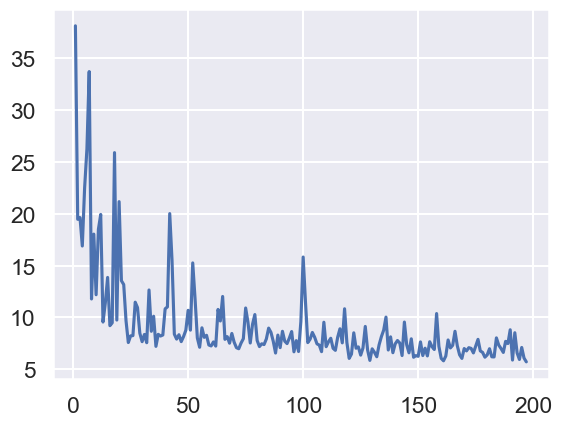

In [63]:
##grafico de la evolucion del aprendizaje neuronal
plt.plot(df["epoch"],df["train_loss"])

In [64]:
##Obtengo los valores predichos por el modelo de red neuronal
predicted = model(X_esc).cpu().detach().numpy()
predicted = np.squeeze(predicted)

In [65]:
#print(df["train_loss"].idxmin(0)) # encontramos la época donde el "loss" es menor

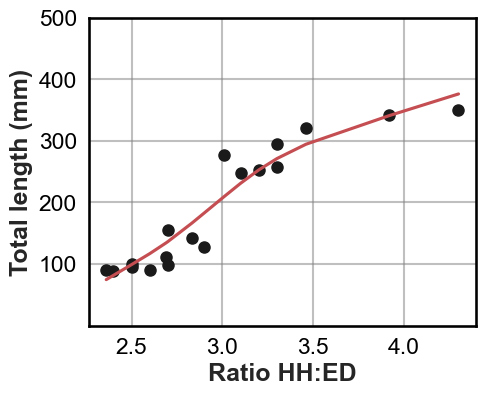

In [66]:
##Ordeno los puntos para graficar
ord_ind = np.argsort(X_escrofalo)
X_escrofalo = X_escrofalo[ord_ind]
y_escrofalo = y_escrofalo[ord_ind]

predicted = predicted[ord_ind]

fig,ax = plt.subplots(1,1,figsize=(5, 4))
ax.set_facecolor("white") 
plt.plot(X_escrofalo, y_escrofalo, 'ko', markersize=8)
plt.plot(X_escrofalo, predicted, 'r-')

ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

plt.ylim(0, 500)
plt.yticks([100,200,300,400,500])

plt.xlabel("Ratio HH:ED", fontweight='bold')
plt.ylabel("Total length (mm)", fontweight='bold')
  
#plt.title("Sebastes oculatus")

plt.tick_params(axis='both', direction='out', length=5, width=1, colors='black',grid_color='grey', grid_alpha=0.5)

#plt.savefig('RedNeuronal_escrofalo.tiff', dpi=300, bbox_inches='tight', facecolor='white')

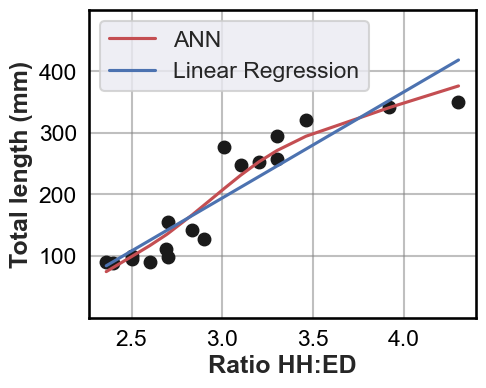

In [67]:
##Ordeno los puntos para graficar
ord_ind = np.argsort(X_escrofalo)
X_escrofalo = X_escrofalo[ord_ind]
y_escrofalo = y_escrofalo[ord_ind]

#ANN
predicted_ann = predicted[ord_ind]

#regression
predicted_LinReg =  172.2*X_escrofalo - 322.2  

fig,ax = plt.subplots(1,1,figsize=(5, 4))
ax.set_facecolor("white") 
plt.plot(X_escrofalo, y_escrofalo, 'ko')
plt.plot(X_escrofalo, predicted_ann, 'r-', label ="ANN")
plt.plot(X_escrofalo, predicted_reg, 'b-', label ="Linear Regression")


ax.spines['bottom'].set_color('black')
ax.spines['top'].set_color('black')
ax.spines['left'].set_color('black')
ax.spines['right'].set_color('black')

plt.ylim(0, 500)
plt.yticks([100,200,300,400])

plt.xlabel("Ratio HH:ED", fontweight='bold')

plt.ylabel("Total length (mm)", fontweight='bold')
plt.legend()  
#plt.title("Sebastes oculatus")

plt.tick_params(axis='both', direction='out', length=5, width=1, colors='black',grid_color='grey', grid_alpha=0.5)

#plt.savefig('RedNeuronal_escrofalo_comparison.tiff', dpi=300, bbox_inches='tight', facecolor='white')

-El uso de A.I (redes neuronales) representa una poderosa técnica de modelado con ventajas sobre las regresiones convencionales cuando se desconoce la asociación subyacente entre variables y los datos tienen "ruido". A continuación, compararemos el rendimiento (error y R2) entre ANN y modelos lineales para verificar que se cumplan estas ventajas.

-The use of A.I (neural networks) represent a powerful modelling technique with advantages over conventional regressions when the underlying association between variables is unknown and data is noisy. Next, we will compare the performance (error and R2 metrics) between ANN and linear models to verify that these advantages are met.

<h5> Defino diversos índices de error </h5>  

In [68]:
def mae(y_value, predictions): #Mean Absolute Error
    y_value, predictions = np.array(y_value), np.array(predictions)
    return np.mean(np.abs(y_value - predictions))

In [69]:
def mrae(y_value, predictions): #Mean Relative Absolute Error
    y_value, predictions = np.array(y_value), np.array(predictions)
    return np.mean((np.abs(y_value - predictions))/np.abs(y_value))

In [70]:
def mape(actual, predicted):   #Mean Absolute Percentage Error
    return np.mean(np.abs((actual - predicted) / actual)) * 100

In [71]:
#MÉTRICAS DE ERROR PARA RED NEURONAL ARTIFICIAL (ANN):
metrics_ann= {'mae': mae(y_escrofalo,predicted), 'mrae': mrae(y_escrofalo,predicted), 'mape':mape(y_escrofalo,predicted)}
metrics_ann=pd.DataFrame(metrics_ann, index=['Escrofalo'])
metrics_ann
#metrics_ann.to_csv('escrofalo_metrics.csv')

,mae,mrae,mape
Escrofalo,21.516827,0.139426,13.942558


In [72]:
#MÉTRICAS DE ERROR PARA REGRESIÓN LINEAL:
metrics_RegLin= {'mae': mae(y_escrofalo,predicted_reg), 'mrae': mrae(y_escrofalo,predicted_reg), 'mape':mape(y_escrofalo,predicted_reg)}
metrics_RegLin=pd.DataFrame(metrics_RegLin, index=['Escrofalo'])
metrics_RegLin

,mae,mrae,mape
Escrofalo,30.647821,0.176363,17.63632


<b> Vemos que el error es menor en el modelo de red neuronal (ANN) en todas las métricas </b> 
<h5> the error is lower in the neural network (ANN) model with all metrics used </h5>

<h5> Calculo el coeficiente de determinación (R2) </h5>  

In [74]:
#Calculo R2
y_bar = np.mean(y_escrofalo)
SS_res = np.sum((y_escrofalo - np.squeeze(predicted))**2)
SS_tot = np.sum((y_bar - np.squeeze(predicted))**2)
R2_ann = 1-SS_res/SS_tot
print(R2_ann)

0.9030013468533435


R2 = 0.90 implica que el model oes capaz de explicar el 90% de la variabilidad de la talla total (total length) en esta especie.
<h6> R2 value implies that the model is capable of explaining 90% of the variability of total length in this species </h6>

In [75]:
#Calculo R2
y_bar = np.mean(y_escrofalo)
SS_res = np.sum((y_escrofalo - predicted_reg)**2)
SS_tot = np.sum((y_bar - predicted_reg)**2)
R2_LinReg = 1-SS_res/SS_tot
print(R2_LinReg)

0.8182371710565394


<b> Vemos que el R2 es mayor en el modelo de red neuronal (ANN), por lo que dicho modelo explica mejor las variaciones en la talla total cuando cambia el head/eye ratio </b> 
<h5> The R2 is greater in the neural network (ANN) model, so this model better explains the variations in total length when the head/eye ratio changes.

<h4> Hago predicciones de talla para nuevos datos: </h4>

In [76]:
#REPLACE FOR YOUR PC ROUTE:
df_test=pd.read_csv('C:\\Users\\merlo\\Documents\\Doctorado\\CapituloI_LengthEstimations\\newdata_df.csv',encoding='unicode_escape')
tab_escrofalo_test = df_test[(df_test['Especie']=='Escrofalo')][['R_cab_ojo','Waypoints']].reset_index(drop=True)
np_escrofalo_test=tab_escrofalo_test.to_numpy(copy=True)
n_muestras = len(np_escrofalo_test)

X_escrofalo_test = np_escrofalo_test[:,0].astype(np.float32)

tab_length = df_test[(df_test['Especie']=='Escrofalo')][['Length']].reset_index(drop=True)
np_tab_length=tab_length.to_numpy(copy=True)
np_length = np_tab_length[:,0].astype(np.float32)


X_m_test=torch.from_numpy(X_escrofalo_test.astype(np.float32)).to(device)
X_m_test = X_m_test.view(X_m_test.shape[0], 1)

predicted_test = model(X_m_test).cpu().detach().numpy()
predicted_test = np.squeeze(predicted_test)
predicted_test[0:10] #veo los primeros valores predichos para un nuevo set de datos.

array([358.42438, 220.18343, 359.09164, 304.74786,  73.4556 , 136.53157,
       297.9433 , 287.7533 , 241.0498 ,  55.55863], dtype=float32)

<h4> Guardamos el modelo </h4>
---------------------

Una forma estándar de guardar el modelo es "serializar" el diccionario con el estado interno del mismo, el cual contiene los parámetros del modelo.

In [ ]:
torch.save(model.state_dict(), "model_escrofalo.pth")
print("Saved PyTorch Model State to model_escrofalo.pth")

<h4> Cargamos un modelo guardado </h4>
----------------------------

Para cargar un modelo almacenado, tenemos que recrear la estructura del modelo (definir una nueva instancia de nuestra clase) y cargar el diccionario con el estado interno (los parámetros).